In [1]:
# ==========================================
# GMM Model Selection: 2–8 clusters
# ==========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data
train_df = pd.read_csv("/kaggle/input/travel-behavior-insights/train.csv")

TARGET = "spend_category"
train_df = train_df.dropna(subset=[TARGET]).reset_index(drop=True)

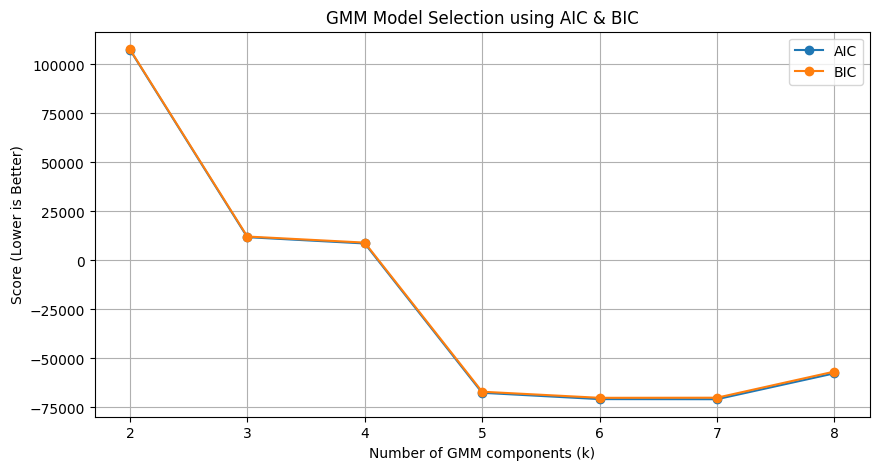


 Best GMM cluster count (BIC): 6


In [2]:
y = train_df[TARGET].astype(int)
X = train_df.drop(columns=[TARGET])

# Select numeric features for clustering
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

X_num = X[num_cols].fillna(X[num_cols].median())

# Scale numeric data (important for GMM!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

k_range = range(2, 9)
aic_scores = []
bic_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    aic_scores.append(gmm.aic(X_scaled))
    bic_scores.append(gmm.bic(X_scaled))

# Plot AIC & BIC
plt.figure(figsize=(10, 5))
plt.plot(k_range, aic_scores, marker='o', label="AIC")
plt.plot(k_range, bic_scores, marker='o', label="BIC")
plt.xlabel("Number of GMM components (k)")
plt.ylabel("Score (Lower is Better)")
plt.title("GMM Model Selection using AIC & BIC")
plt.grid(True)
plt.legend()
plt.show()

# Best K based on BIC (usually most reliable)
best_k = k_range[np.argmin(bic_scores)]
print("\n Best GMM cluster count (BIC):", best_k)

In [3]:
# ======================================================
# FINAL MODEL: GMM + CatBoost + Logistic Regression Stack
# ======================================================

# Load Data
train_df = pd.read_csv("/kaggle/input/travel-behavior-insights/train.csv")
test_df  = pd.read_csv("/kaggle/input/travel-behavior-insights/test.csv")

TARGET = "spend_category"
IDCOL = "trip_id"

train_df = train_df.dropna(subset=[TARGET]).reset_index(drop=True)
y = train_df[TARGET].astype(int)

X = train_df.drop(columns=[TARGET])
X_test = test_df.copy()

In [4]:
# ------------------------
# Numeric Imputation + Scaling
# ------------------------
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

X_num = X[num_cols].fillna(X[num_cols].median())
X_test_num = X_test[num_cols].fillna(X_num.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_test_scaled = scaler.transform(X_test_num)

In [5]:
# ------------------------
# GMM Clustering — K=6
# ------------------------
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

train_cluster_probs = gmm.predict_proba(X_scaled)
test_cluster_probs  = gmm.predict_proba(X_test_scaled)

# Add cluster prob features
for i in range(best_k):
    X[f"GMM_prob_{i}"] = train_cluster_probs[:, i]
    X_test[f"GMM_prob_{i}"] = test_cluster_probs[:, i]

In [6]:
# ------------------------
# Train/Val Split
# ------------------------
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Fill missing categorical values
for col in cat_cols:
    X[col] = X[col].astype(str).replace(["", " ", "nan"], "Unknown")
    X_test[col] = X_test[col].astype(str).replace(["", " ", "nan"], "Unknown")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
# ------------------------
# Level-1: CatBoost Model
# ------------------------
cat_model = CatBoostClassifier(
    iterations=1300,
    learning_rate=0.03,
    depth=8,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    cat_features=cat_cols,
    verbose=False,
    random_seed=42
)

cat_model.fit(X_train, y_train)

# Validation Score
val_preds = cat_model.predict(X_val)
cat_f1 = f1_score(y_val, val_preds, average="macro")
print("CatBoost F1:", round(cat_f1, 4))

CatBoost F1: 0.6936


In [8]:
# ------------------------
# Level-2: Logistic Regression Meta Learner
# ------------------------
val_probs = cat_model.predict_proba(X_val)
val_df = pd.DataFrame(val_probs)

meta = LogisticRegression(max_iter=2500, class_weight='balanced', multi_class='multinomial')
meta.fit(val_df, y_val)

stack_preds = meta.predict(val_df)
stack_f1 = f1_score(y_val, stack_preds, average='macro')
print("STACKED Validation F1:", round(stack_f1, 4))

STACKED Validation F1: 0.698


In [9]:
# ======================================================
# Retrain CatBoost on full train + final submission
# ======================================================
cat_model.fit(X, y)
test_probs = cat_model.predict_proba(X_test)
test_preds = meta.predict(test_probs)

submission = pd.DataFrame({
    IDCOL: test_df[IDCOL],
    TARGET: test_preds
})

save_path = "/kaggle/working/submission.csv"
submission.to_csv(save_path, index=False)
print("\nSubmission saved :", save_path)
submission.head()


Submission saved : /kaggle/working/submission.csv


,trip_id,spend_category
0,tour_id8gzpck76,2
1,tour_idow1zxkou,0
2,tour_idue7esfqz,0
3,tour_idnj3mjzpb,0
4,tour_ida3us5yk2,0
